In [1]:
import random
import wandb
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T 

from query_strategies import *
from augmentation import *
from model import *
from model_wrapper import *
from trainers import *
from util import *

from hivegraph.contrastive.grace import GRACE

from GRACE_new import GRACENew
import matplotlib.pyplot as plt
import numpy as np

In [2]:
random.seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
DROPOUT= 0.3
NUM_PASSES = 300
BUDGET = 41
EPOCHS = 100
SIGNIFICANCE_ITERATIONS = 10

NOISE_PROB = 0.4
NOISE_LEVEL = 0.5
LATENT_NOISE_LEVEL = 0.25

In [4]:
class AugmentGraphLogitChange(AugmentedQueryStrategy):
    def __init__(self,augmentation_fn, num_passes=10, original_weight = 0.0):
        super().__init__(augmentation_fn, num_passes)
        self.original_weight = original_weight
        
    def __call__(self,model,data, train_pool):
        pool_indices = get_mask_indices(train_pool)
        model.eval()
        orig_out = model.test_step(data)
        out = torch.zeros_like(orig_out)
        entropies = []
        for i in range(self.num_passes):
            data_tmp = data.clone()
            data_tmp = self.augmentation_fn(data_tmp)
            out += model.test_step(data_tmp)
            out_avg = out / (i+1)
            entropies.append(calculate_entropy(out_avg))
        out = out / self.num_passes
        
        
        logit_change = out + self.original_weight * orig_out
        
        entropy = calculate_entropy(logit_change)
        entropies.append(entropy)
        chosen_node_ix = torch.argmax(entropy[pool_indices])
        chosen_node = pool_indices[chosen_node_ix]
        entropies = torch.stack(entropies)
        return chosen_node, entropies
    
    def  __concat_params__(self,fn) -> str:
        return super().__concat_params__(fn) + f", original_weight={self.original_weight}"

In [5]:
class AugmentGraphExpectedGraph(AugmentedQueryStrategy):
    def __init__(self,augmentation_fn, num_passes=10, original_weight = 0.0):
        super().__init__(augmentation_fn, num_passes)
        self.original_weight = original_weight
        
    def __call__(self,model,data, train_pool):
        pool_indices = get_mask_indices(train_pool).cpu()
        model.eval()
        orig_latent = model(data).detach().cpu()
        latent = torch.zeros_like(orig_latent).cpu()
        entropies = []
        for i in range(self.num_passes):
            data_tmp = data.clone()
            data_tmp = self.augmentation_fn(data_tmp)
            latent += model(data_tmp).detach().cpu()
            
            latent_avg = latent / (i+1)
            orig_avg = model.predict_log_proba(latent_avg.detach().cpu().numpy())
            entropies.append(calculate_entropy(torch.tensor(orig_avg)).detach().cpu())
            del latent_avg, data_tmp
            
        latent = latent / self.num_passes
        
        expected_latent = latent + self.original_weight * orig_latent
        out = model.predict_log_proba(expected_latent.detach().cpu().numpy())
        entropy = calculate_entropy(torch.tensor(out))
        entropies.append(entropy)
        
        chosen_node_ix = torch.argmax(entropy[pool_indices])
        chosen_node = pool_indices[chosen_node_ix]
        entropies = torch.stack(entropies)
        return chosen_node, entropies
    
    def  __concat_params__(self,fn) -> str:
        return super().__concat_params__(fn) + f", original_weight={self.original_weight}"

In [6]:
class AugmentGraphSumEntropyQuery(AugmentedQueryStrategy):
    def __init__(self,augmentation_fn, num_passes=10, original_weight = 0.0):
        super().__init__(augmentation_fn, num_passes)
        self.original_weight = original_weight

        
    def __call__(self,model,data, train_pool):
        pool_indices = get_mask_indices(train_pool)
        model.eval()
        entropy_sum = torch.zeros(data.num_nodes).to(data.x.device)
        entropies = []
        for _ in range(self.num_passes):
            data_tmp = data.clone()
            data_tmp = self.augmentation_fn(data_tmp)
            out = model.test_step(data_tmp)
            entropy = calculate_entropy(out)
            entropies.append(entropy)
            entropy_sum += entropy
        entropy_sum /= self.num_passes
        orig_out = model.test_step(data)
        entropy = calculate_entropy(orig_out)
        entropy_sum += self.original_weight * entropy
        entropies.append(entropy)
            
        chosen_node_ix = torch.argmax(entropy_sum[pool_indices])
        chosen_node = pool_indices[chosen_node_ix]
        entropies = torch.stack(entropies)
        return chosen_node, entropies
    def  __concat_params__(self,fn) -> str:
        return super().__concat_params__(fn) + f", original_weight={self.original_weight}"

In [7]:
class AugmentGraphSumEntropyQueryNeighborhood(AugmentedQueryStrategy):
    def __init__(self,augmentation_fn, num_passes=10,n_hop = 2, original_weight = 0.0):
        super().__init__(augmentation_fn, num_passes)
        self.original_weight = original_weight
        self.n_hop = n_hop
        
    def __call__(self,model,data, train_pool):
        pool_indices = get_mask_indices(train_pool)
        model.eval()
        entropy_sum = torch.zeros(data.num_nodes).to(data.x.device)

        for _ in range(self.num_passes):
            data_tmp = data.clone()
            data_tmp = self.augmentation_fn(data_tmp)
            out = model.test_step(data_tmp)
            entropy = calculate_entropy(out)
            entropy_sum += entropy
        entropy_sum /= self.num_passes
        orig_out = model.test_step(data)
        entropy = calculate_entropy(orig_out)
        entropy_sum += self.original_weight * entropy
            
        
        adjaceny = to_dense_adj(data.edge_index)
        for _ in range(self.n_hop):
            entropy_sum = torch.matmul(adjaceny,entropy_sum)[0]
        chosen_node_ix = torch.argmax(entropy_sum[pool_indices])
        
        chosen_node = pool_indices[chosen_node_ix]
        
        return chosen_node
    
    def  __concat_params__(self,fn) -> str:
        return super().__concat_params__(fn) + f", original_weight={self.original_weight}"

In [8]:
drop_edge = DropEdge(DROPOUT)
noise_feature_all = NoiseFeature(NOISE_LEVEL, 1)
drop_edge_noise_all = T.Compose([drop_edge, noise_feature_all])

augment_sum_entropy_with_original = AugmentGraphSumEntropyQuery(drop_edge_noise_all, NUM_PASSES, 1.0)
augment_logit_change = AugmentGraphLogitChange(drop_edge_noise_all, NUM_PASSES,0.0)
augment_expected_graph = AugmentGraphExpectedGraph(drop_edge_noise_all, NUM_PASSES, 0.0)
augmented_sum_neighbor = AugmentGraphSumEntropyQueryNeighborhood(drop_edge_noise_all, NUM_PASSES, 1, 0.0)

In [1]:
data_splits = [torch.load(f"data_splits/split_{i}.pt") for i in range(10)]
dataset = data_splits[0].to(device)


NameError: name 'torch' is not defined

In [10]:
model = GRACENew(num_features=dataset.num_features,hidden=128, num_layers=2,
                 drop_edge_rate_1=0.3,drop_edge_rate_2=0.3,
                 drop_feature_rate_1=0.3,drop_feature_rate_2=0.3,
                 ratio=0.5).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
wrapped_model = GRACEModelWrapper(model,optimizer)
trainer = Trainer()

In [11]:
trainer.train(wrapped_model, dataset, 200)
print("Training done")

Training done


In [12]:
strategy1 = augment_logit_change
strategy2 = augment_sum_entropy_with_original
strategy3 = augment_expected_graph

In [13]:
strat_accuracies = []
strat_entropies = []
for strategy in [augmented_sum_neighbor]:
        data_splits = [torch.load(f"data_splits/split_{i}.pt") for i in range(10)]
        budget_accuracies = []
        budget_entropies = []
        dataset = data_splits[0].to(device).clone()

        for b in range(1,BUDGET+1):
                print(f"Budget {b}")

                
                num_features = dataset.num_features
                num_classes = dataset.y.max().item() + 1
                
                wrapped_model = wrapped_model
                labels = label_indices(dataset)
                # if b % 10 == 0:
                #     trainer = Trainer()
                #     trainer.train(wrapped_model, dataset, 200)
                
                
                out_a = wrapped_model(dataset)
                
                acc = trainer.test(wrapped_model, dataset)
                del out_a
                chosen_node = strategy(wrapped_model, dataset, dataset.train_pool)
                
                # chosen_node2,entropies2 = strategy2(wrapped_model, dataset, dataset.train_pool)
                dataset.train_pool[chosen_node] = False
                dataset.train_mask[chosen_node] = True
                budget_accuracies.append(acc)
                # budget_entropies.append(entropies)
                # budget_entropies2.append(entropies2)
                
                wrapped_model.reset_predictor()
        strat_accuracies.append(budget_accuracies)
        strat_entropies.append(budget_entropies)
        print(f"{strategy} done")


/tmp/ipykernel_1178423/1658822483.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_splits = [torch.load(f"data_splits/split_{i}.pt") for i in range(10)]


Budget 1
Budget 2
Budget 3
Budget 4
Budget 5
Budget 6
Budget 7
Budget 8
Budget 9
Budget 10
Budget 11
Budget 12
Budget 13
Budget 14
Budget 15
Budget 16
Budget 17
Budget 18
Budget 19
Budget 20
Budget 21
Budget 22
Budget 23
Budget 24
Budget 25
Budget 26
Budget 27
Budget 28
Budget 29
Budget 30
Budget 31
Budget 32
Budget 33
Budget 34
Budget 35
Budget 36
Budget 37
Budget 38
Budget 39
Budget 40
Budget 41
AugmentGraphSumEntropyQueryNeighborhood([DropEdge, NoiseFeature], original_weight=0.0) done


In [14]:
budget_entropies[0]

IndexError: list index out of range

In [17]:
strat_accuracies

[[tensor(0.5130, device='cuda:0'),
  tensor(0.4830, device='cuda:0'),
  tensor(0.4380, device='cuda:0'),
  tensor(0.3130, device='cuda:0'),
  tensor(0.5140, device='cuda:0'),
  tensor(0.4910, device='cuda:0'),
  tensor(0.4930, device='cuda:0'),
  tensor(0.3950, device='cuda:0'),
  tensor(0.4550, device='cuda:0'),
  tensor(0.4410, device='cuda:0'),
  tensor(0.4910, device='cuda:0'),
  tensor(0.5320, device='cuda:0'),
  tensor(0.5090, device='cuda:0'),
  tensor(0.6100, device='cuda:0'),
  tensor(0.6010, device='cuda:0'),
  tensor(0.6110, device='cuda:0'),
  tensor(0.6700, device='cuda:0'),
  tensor(0.6650, device='cuda:0'),
  tensor(0.6840, device='cuda:0'),
  tensor(0.6810, device='cuda:0'),
  tensor(0.6840, device='cuda:0'),
  tensor(0.6780, device='cuda:0'),
  tensor(0.7010, device='cuda:0'),
  tensor(0.6900, device='cuda:0'),
  tensor(0.6930, device='cuda:0'),
  tensor(0.7010, device='cuda:0'),
  tensor(0.6940, device='cuda:0'),
  tensor(0.6820, device='cuda:0'),
  tensor(0.6980, dev

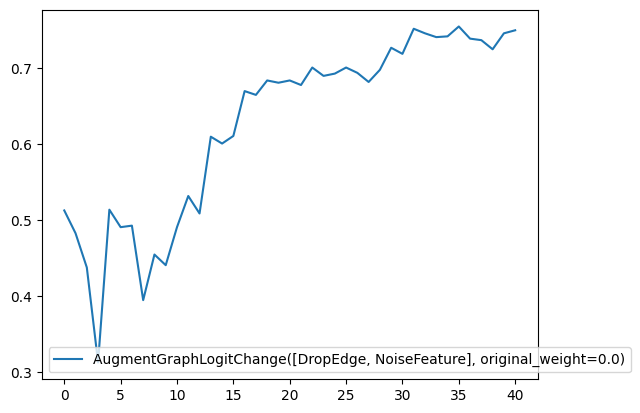

In [16]:
for strat_acc,strat in zip(strat_accuracies, [strategy1, strategy2, strategy3]):
    strat_acc = torch.tensor(strat_acc).cpu().numpy()
    plt.plot(strat_acc, label=str(strat))
plt.legend()
plt.show()

In [ ]:
budget_entropies[0].mean(dim=0)

tensor([1.9336, 1.9200, 1.9350,  ..., 1.9074, 1.9236, 1.9293],
       dtype=torch.float64)

In [ ]:
chosen_node

tensor(134)

/tmp/ipykernel_1175635/3506461478.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


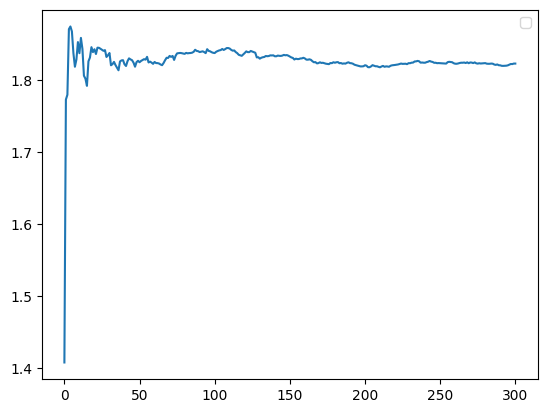

In [ ]:

ix = 5
max_std_node_entorpies =budget_entropies[40][:,ix].cpu().detach().numpy()
cum_avg = max_std_node_entorpies


# plt.plot(np.repeat(max_std_node_entorpies[-1],300), label="Original")
plt.plot(cum_avg)

plt.legend()
plt.show()


In [ ]:
budget_entropies = torch.stack(budget_entropies)

In [ ]:
budget_entropies.mean(dim=0)

tensor([[1.7276, 1.6235, 1.7414,  ..., 1.6478, 1.7387, 1.8134],
        [1.7859, 1.6922, 1.7592,  ..., 1.7434, 1.7871, 1.8309],
        [1.8126, 1.7514, 1.7807,  ..., 1.7832, 1.7782, 1.8368],
        ...,
        [1.8646, 1.8084, 1.8150,  ..., 1.8761, 1.8249, 1.8599],
        [1.8646, 1.8086, 1.8151,  ..., 1.8760, 1.8249, 1.8599],
        [1.8646, 1.8086, 1.8151,  ..., 1.8760, 1.8249, 1.8599]],
       dtype=torch.float64)